# Task #5.2: find the Flux!

What is flux calibration? Up to now, the extracted spectrum that we have gives the flux (for each wavelength bin) in units of counts on the detector. We want to convert the flux from counts/s/Å (taking into account the exposure time) to erg/cm²/s/Å..

Why do we do this calibration? We want to know the flux emitted by our source in physical units. This allows to use our measurents for deriving other physical quantities for example.

How? First step is to derive the intrinsic flux of the standard star from our observed spectrum taking into account the atmospheric absorption. Then we can just compare this intrinsic spectrum to the reference spectrum in physical units and derive a sensitivity function.

In [2]:
# Importing all needed packages
# Standard packages for data visualization and modeling
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules 
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *

# Other
import datetime
import timeit
from regions import RectanglePixelRegion
from IPython.display import IFrame   # to open and view a pdf in the notebook

# Get the intrinsic flux from standard star

We derive the intrinsic flux of the standard star with the equation written in the comments below, which uses the atmospheric extinction coefficient (typical in La Palma) and the airmass of the observation.

First we interpolate the extinction law (so that we have a coefficient value for each wavelength bin of the standard star spectrum) and we show in a plot the wavelength range relevant for our data.

Then we open the standard star frame and read:

-> the airmass

-> the exposure time

-> the history of the file (bias-subtraction and flat-normalization)

Finally we plot the observed standard star spectrum and the derived intrinsic spectrum. 

<IPython.core.display.Javascript object>


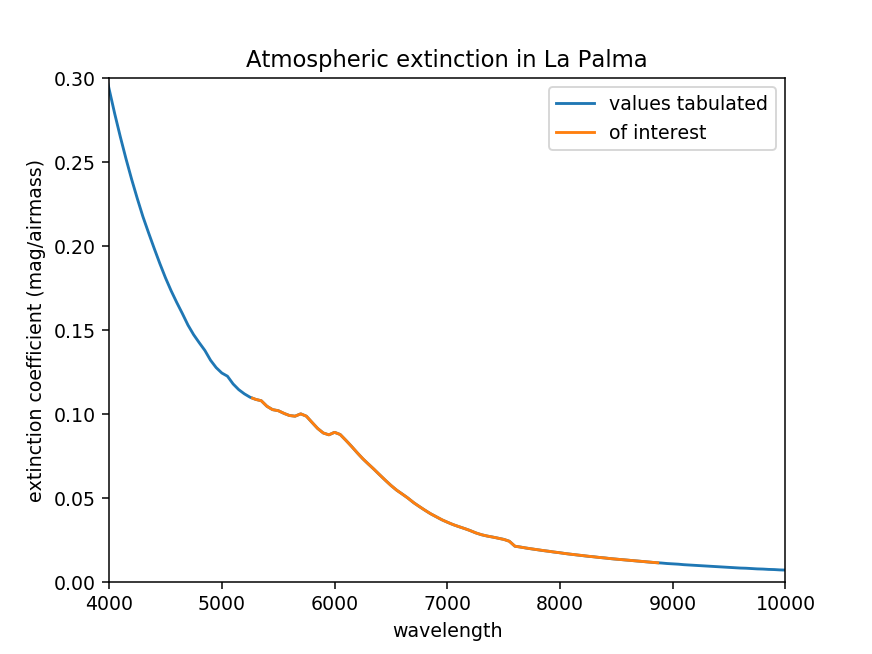

Airmass: 1.1853044941568
Exposure time: 60.0
HISTORY: Master Bias subtracted on 2021-02-19 17:32:48 using master bias file /ho
me/masi1109/Documents/PhD/ObsII/not2mattia/master_bias_mean.fits
Master flat divided on: 2021-02-19 17:33:45 using master flat file /home
/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits


<IPython.core.display.Javascript object>


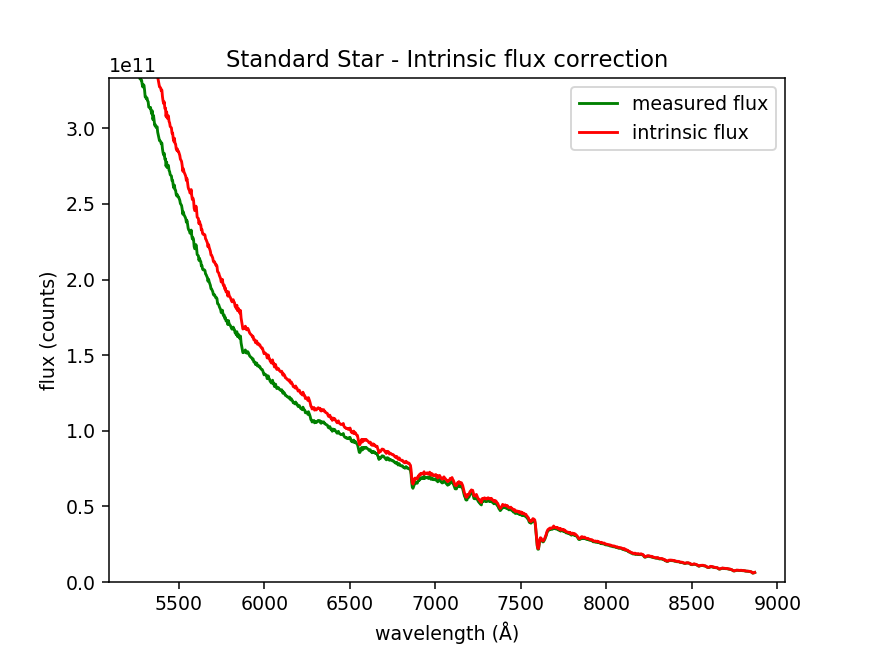

In [3]:
# Atmospheric extinction above the observatory on La Palma is typically 0.12 mag in V band, 
# and varies with wavelength (file importeed below). 
# See La Palma technical note 31 (King 1985) for further information. 

# Extinctions (k) are measured using magnitudes: m - m' = k*X    (primed quantities are the intrinsic ones)
# Magnitude definition is: m - m' = -2.5 log10 (I / I')
# Therefore: I' / I = 10**(k*X/2.5)
# where k is the extinction coefficient, dependent on the wavelength, and X is the airmass

file_ext = "/home/masi1109/Documents/PhD/ObsII/wl_ext_LaPalma.dat"
wl, k = np.loadtxt(file_ext, unpack=True)

plt.figure()
plt.title("Atmospheric extinction in La Palma")
plt.plot(wl, k, label="values tabulated")
plt.xlabel("wavelength")
plt.ylabel("extinction coefficient (mag/airmass)")
plt.xlim(4000,10000)
plt.ylim(0,0.3)

# I need to interpolate this extinction law at each wavelength value of the std star spectrum
ext_law = sp.interpolate.interp1d(wl, k, fill_value="extrapolate")

# Importing std star spectrum extracted in previous workbook (5.1)
path2data = '/home/masi1109/Documents/PhD/ObsII/not2mattia'
file_std = path2data + "/ALAe130155_1dSpectrum_wav-cal.txt"
lam_std, flux_std = np.loadtxt(file_std, unpack=True)

plt.plot(lam_std, ext_law(lam_std), label="of interest")
plt.legend()

# Reading the Airmass value of the std star and Printing basic checks
file = path2data + "/ALAe130155_b_f.fits"
hdul = fits.open(file) 
if hdul[0].header['IMAGETYP'] == 'OBJECT' and hdul[0].header['OBS_MODE'] == 'SPECTROSCOPY':
    airmass_std = hdul[0].header['AIRMASS']
    exp_time_std = hdul[0].header['EXPTIME']
    print("Airmass:", airmass_std)
    print("Exposure time:", exp_time_std)
    # checking bias subtraction and flat normalization
    flat_check = hdul[0].header['HISTORY']
    print("HISTORY:", flat_check)
hdul.close()

# Computing the intrinsic flux
flux_std_int = flux_std * 10**(ext_law(lam_std) * airmass_std / 2.5)

plt.figure()
plt.title("Standard Star - Intrinsic flux correction")
plt.plot(lam_std, flux_std, c="green", label="measured flux")
plt.plot(lam_std, flux_std_int, c="red", label="intrinsic flux")
plt.ylim(0, flux_std.max())
plt.xlabel("wavelength (Å)")
plt.ylabel("flux (counts)")
plt.legend()

# Compare with the spectrum in physical units and find the sensitivity function

In the cell below we import the spectrum of the standard star in physical units and we resample it to the same spectral resolution of our data. This means to have both spectra with the sae wavelength bins and it can be done using a function called "spectres" defined in the file "spectres.py".

We plot the spectrum in physical units, the resampled version and, on top, the derived intrinsic spectrum scaled to the same value of the y-coordinate.

We then find the sestivity function by simply taking the ratio of flux in physical units and the flux in counts divided by the exposure time. We expect this function to be smooth so we fit a polynomial to it and get rid of the noise as shown in the plot below.

<IPython.core.display.Javascript object>


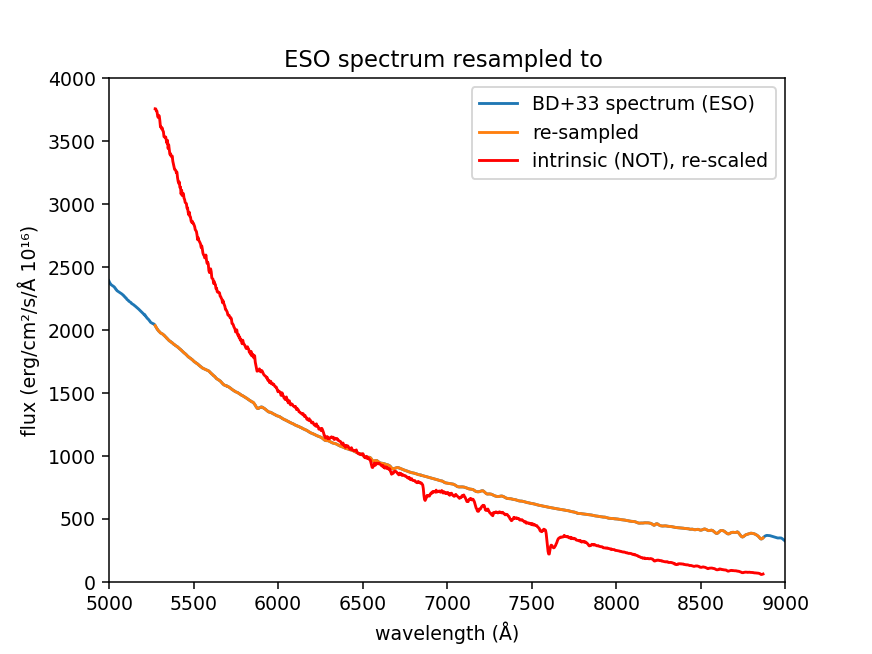

<IPython.core.display.Javascript object>


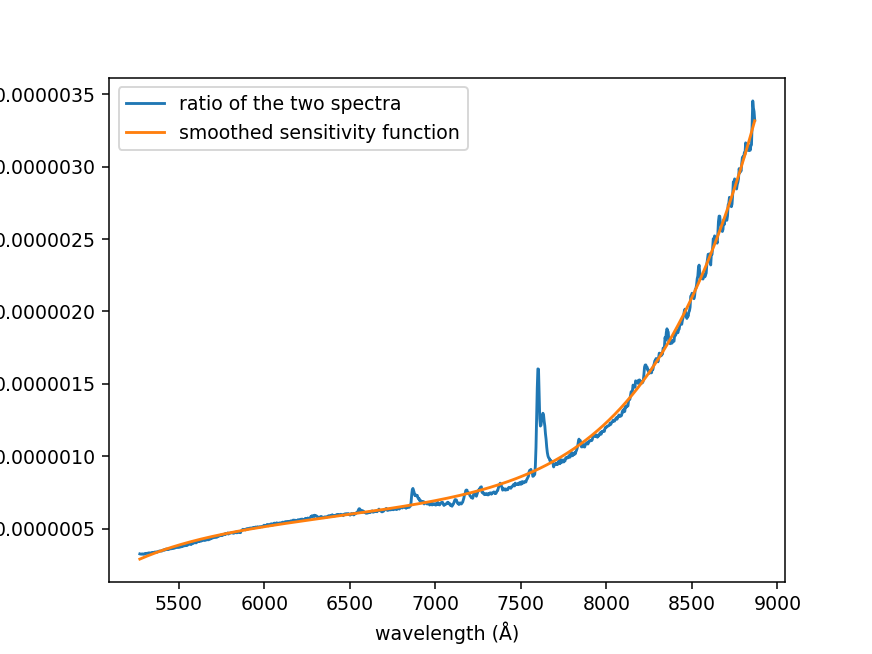

In [4]:
# Download spectrum in physical units of the standard star that has been observed
# BD+33 spectrum given on the ESO webpage 
# https://www.eso.org/sci/observing/tools/standards/spectra/bd33d2642.html

# Should you need other standard stars, please find more info here: 
# https://www.eso.org/sci/observing/tools/standards/spectra.html
# and the files here: ftp://ftp.eso.org/pub/stecf/standards/okestan/ 

# File saved as /home/masi1109/Documents/PhD/ObsII/fbd33d2642.dat
# For more info see: /home/masi1109/Documents/PhD/ObsII/aaareadme.oke 

file_name = "/home/masi1109/Documents/PhD/ObsII/fbd33d2642.dat"
lam, flam_erg, flam_Jy, dlam = np.loadtxt(file_name, unpack=True)
plt.figure()
plt.plot(lam, flam_erg, label="BD+33 spectrum (ESO)")
plt.plot()
plt.xlabel("wavelength (Å)")
plt.ylabel("flux (erg/cm²/s/Å 10¹⁶)")

# I must resample the ESO spectrum to the same wavelength bins of the extracted spectrum
# For this I use a function defined in spectres.py by A. C. Carnall
# The argument of this function are: original wavelength array of the spectrum, 
# original flux array of the spectrum, new wavelength array desired

from spectres import spectres
flam_erg_re = spectres(lam, flam_erg, lam_std)

plt.title("ESO spectrum resampled to ")
plt.plot(lam_std, flam_erg_re, label="re-sampled")
plt.plot(lam_std, flux_std_int*1e-8, c="red", label="intrinsic (NOT), re-scaled")
plt.xlim(5000, 9000)
plt.ylim(0, 4000)
plt.legend()

# Sensitivity function is the ratio between flux in physical units and intrinsic flux per EXPOSURE TIME
# (this is a function of the wavelength)

fsen = sp.interpolate.interp1d(lam_std, flam_erg_re / (flux_std_int / exp_time_std), \
                                     fill_value="extrapolate")
# Fitting a polynomial to smooth the sensitivity function
polyord = 5
poly_fsen = np.polyfit(lam_std, fsen(lam_std), polyord)
conversion = sp.interpolate.interp1d(lam_std, np.polyval(poly_fsen, lam_std), fill_value="extrapolate")

plt.figure()
plt.plot(lam_std, fsen(lam_std), label="ratio of the two spectra")
plt.plot(lam_std, conversion(lam_std), label="smoothed sensitivity function")
plt.xlabel("wavelength (Å)")
plt.legend()

# Get the science spectrum

Finally we import the science spectrum that we want to flux-calibrate and we print:

-> the airmass value

-> the history of the file (bias-subtraction, flat-normalization, and wavelength-calibration)

We derive its intrinsic spectrum correcting for the atmospheric extinction in the same way as we did for the standard star.
We use the sensitivity function to convert its flux to physical units and save the newly flux-calibrated spectrum as a file.

Plotted below are the intrinsic spectrum and the flux-calibrated spectrum.

Airmass: 1.4367415795278
HISTORY: Master Bias subtracted on 2021-02-19 17:32:48 using master bias file /ho
me/masi1109/Documents/PhD/ObsII/not2mattia/master_bias_mean.fits
Master flat divided on: 2021-02-19 17:33:45 using master flat file /home
/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits


<IPython.core.display.Javascript object>


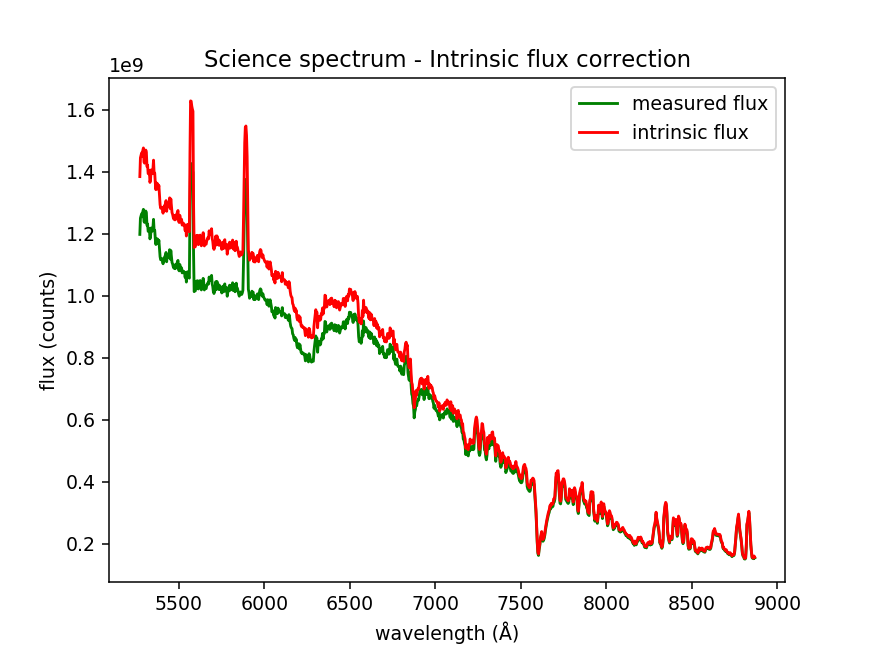

<IPython.core.display.Javascript object>


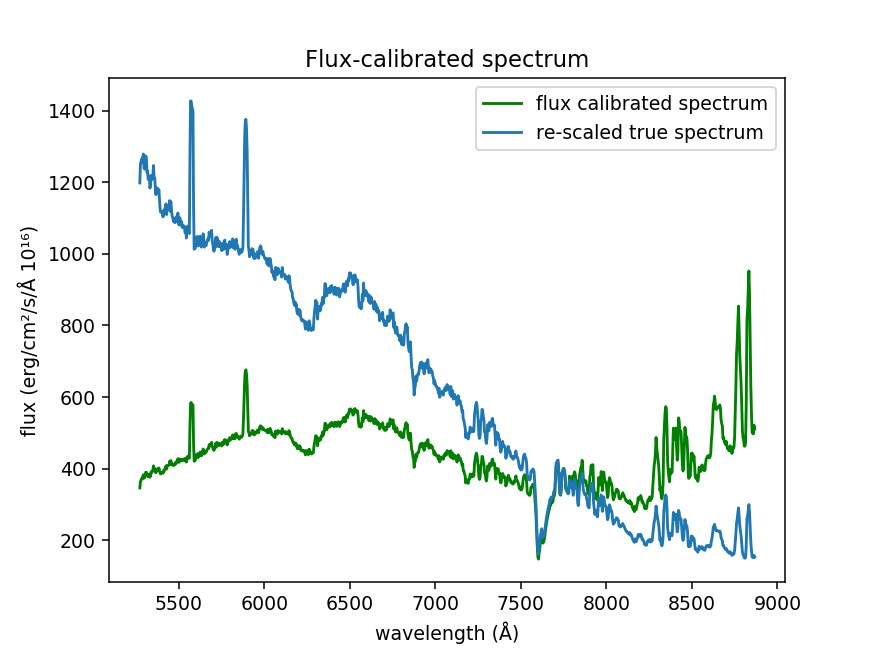

In [5]:
# Import the flux-uncalibrated science spectrum
lam, flam = np.loadtxt(path2data+"/ALAe130145_1dSpectrum_wav-cal.txt", unpack=True)

# Reading the Airmass value of the science obs and printing basic checks
file = path2data + "/ALAe130145_b_f.fits"
hdul = fits.open(file) 
if hdul[0].header['IMAGETYP'] == 'OBJECT' and hdul[0].header['OBS_MODE'] == 'SPECTROSCOPY':
    airmass = hdul[0].header['AIRMASS']
    print("Airmass:", airmass)
    # checking bias subtraction and flat normalization
    flat_check = hdul[0].header['HISTORY']
    print("HISTORY:", flat_check)
hdul.close()

flam_int = flam * 10**(ext_law(lam) * airmass / 2.5)
plt.figure()
plt.title("Science spectrum - Intrinsic flux correction")
plt.plot(lam, flam, c="green", label="measured flux")
plt.plot(lam, flam_int, c="red", label="intrinsic flux")
plt.xlabel("wavelength (Å)")
plt.ylabel("flux (counts)")
plt.legend()

flam_int_cal = flam * conversion(lam) 

plt.figure()
plt.plot(lam, flam_int_cal, c="green", label="flux calibrated spectrum")
plt.plot(lam, flam*1e-6, label="re-scaled true spectrum")
plt.title("Flux-calibrated spectrum")
plt.xlabel("wavelength (Å)")
plt.ylabel("flux (erg/cm²/s/Å 10¹⁶)")
plt.legend()
plt.savefig("figs/SN_spectrum_wav-flux-cal.pdf")

# Saving the calibrated spectrum in a text file
file_out = open(path2data+"/ALAe130145_1dSpectrum_wav-flux-cal.txt", "w")
file_out.write("# 1d spectrum optimally extracted from frame ALAe130145_b_f.fits\n")
file_out.write('# Wavelength calibrated\n')
file_out.write('# Flux calibrated')
file_out.write("# Column 1: wavelength (Å)    Column 2: flux (erg/cm²/s/Å 10¹⁶)\n")

for i in range(len(lam)):
    s = '{:.4f}    {:.4f}\n'.format(lam[i], flam_int_cal[i])
    file_out.write(s)
    
file_out.close()